# Demonstration CPU-based code for array addition

In [154]:
import numpy as np

a = np.ones([3]) # [1. 1. 1.]
b = np.ones([3]) # [1. 1. 1.]

#computation of interest: add b into a
def addition_function(a,b):
    a += b
    
addition_function(a,b)

print(a)

[2. 2. 2.]


# Demonstration GPU-based code for array addition

In [38]:
import numpy as np
from numba import cuda

a = np.ones([3]) # [1. 1. 1.]
b = np.ones([3]) # [1. 1. 1.]

#sends the above arrays to device arrays, existing on the GPU ("Send data to GPU" step)
a_gpu = cuda.to_device(a)
b_gpu = cuda.to_device(b)

#define our CUDA kernel, matching the computation of interest within the loop (+ addition of indices)
@cuda.jit
def addition_kernel(a,b):
    threadID = cuda.grid(1)
    num_threads = cuda.gridsize(1)
    for i in range(threadID, a.shape[0], num_threads): 
        a[i] += b[i] #computation of interest, only change from CPU code is addition of indices
            
threads = 16
blocks = 16

#run kernel with 16 threads, 16 blocks of threads (256 total threads)
addition_kernel[threads, blocks](a_gpu,b_gpu)

a = a_gpu.copy_to_host()

print(a)

[2. 2. 2.]



### Changes between CPU and GPU:

* Import cuda from numba, the GPU-interfacing library in python
* Send (numpy) arrays to the GPU before running calculation
* Define a CUDA kernel, which runs the array calculation in place of numpy. 
    * Include thread ID and number of threads to ensure parallel threads evenly split up the work
    * Loop over the array based on threadID and num_threads, to ensure even distribution of work between threads and no collisions
        * range(start, end, stride) produces an array of values, starting at "start", ending before the value gets to "end", and with the difference between each successive value equal to "stride". 
        * For example, if we have 2 threads (num_threads = 2) and 10 array indices to add (a.shape[0] = 10), threadIDs would be 0 and 1 respectively, and range(0, 10, 2) = [0, 2, 4, 6, 8] and range(1, 10, 2) = [1, 3, 5, 7, 9]. Each thread operates on half of the array, and the threads do not collide with each other
    * Include indices in the code copied from the CPU case!
    * Certain math functions in numpy (trig, exponential, etc.) must use the base math library
    * Self-modification of arrays involving access of neighboring values must be avoided in GPU code to avoid race conditions. (Further explained below)
* Include variables for number of threads and number of {blocks of threads}. The product of these variables will equal the total number of parallel threads used by the kernel.
* Call kernel (similar to calling a function, but with the addition of threads and blocks in the brackets to define the number of threads used by the kernel)
* Retrieve data back into the (numpy) arrays from the GPU after the computation has finished, in order to have access to the data as normal.

May seem complex! However, all this must only be done once. The important case is for the changes that must be made for iteration:

### How to propagate changes from CPU-code to GPU-code:

* Update send/receive sections, as well as kernel parameters, to account for number of arrays used
* Copy the computation of interest into the kernel
* Add indices
* Use math library instead of numpy for math functions
* Avoid race conditions! (Explained below)

#### Example of more complicated computation converted to GPU below (Arithmetic-Geometric mean)

In [162]:
import numpy as np
from numba import cuda

a = np.ones(5) #[1. 1. 1. 1. 1.]
b = np.arange(5.) #[0. 1. 2. 3. 4.]

def agm_function(a,b):
    for step in range(2000):
        c = a
        d = b
        a = 0.5*(c+d) # <-- note that we re-assign the value of a here, therefore results wont be saved in the original array
        b = np.sqrt(c*d)
    return a # so we need to return the final value instead

a = agm_function(a,b)

print(a)

[0.         1.         1.45679103 1.86361678 2.24302858]


In [163]:
import numpy as np
from numba import cuda
import math

a = np.ones(5) #[1. 1. 1. 1. 1.]
b = np.arange(5.) #[0. 1. 2. 3. 4.]

a_gpu = cuda.to_device(a)
b_gpu = cuda.to_device(b)

#define our CUDA kernel, matching the computation of interest within the loop (+ addition of indices)
@cuda.jit
def agm_kernel(a,b):
    threadID = cuda.grid(1)
    num_threads = cuda.gridsize(1)
    for i in range(threadID, a.shape[0], num_threads): 
        #other than renaming the kernel, this is the only section that changed
        for step in range(2000):
            c = a[i]
            d = b[i]
            a[i] = 0.5*(c+d)
            b[i] = math.sqrt(c*d) #notice use of math function for sqrt

threads = 16
blocks = 16

agm_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)

a = array_a_on_the_gpu.copy_to_host()

print(a)

[0.         1.         1.45679103 1.86361678 2.24302858]


# Benchmarking!

GPU-based coding is undeniably more complex than CPU. Therefore, for it to be viable for use, GPU-based code must be faster than CPU-based code.

To measure this, the below code block runs the first computation (add two arrays together), for varying array sizes. Threads and blocks are both set to 64, for a maximum of 4k parallel threads in the GPU computation. 

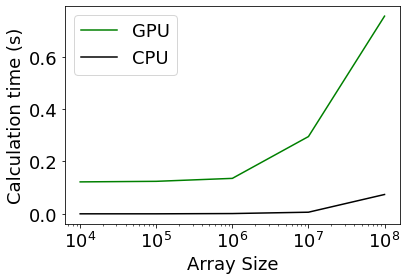

In [169]:
#Timing CPU vs. GPU, function of array size

import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
import time

def cpu_time(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    t0 = time.time()
    a += b
    t1 = time.time()
    return t1-t0

def gpu_time(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    
    @cuda.jit
    def addition_kernel(a,b):
        startx = cuda.grid(1)      
        stridex = cuda.gridsize(1) 
        for i in range(startx, a.shape[0], stridex):
            a[i] += b[i]
            
    threads = 64
    blocks = 64
    
    t0 = time.time()
            
    array_a_on_the_gpu = cuda.to_device(a)
    array_b_on_the_gpu = cuda.to_device(b)

    addition_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)

    a = array_a_on_the_gpu.copy_to_host()
    t1 = time.time()
    return t1-t0
    
array_sizes = [10000, 100000, 1000000, 10000000, 100000000]
cpu_times = []
gpu_times = []
for i in range(len(array_sizes)):
    cpu_times.append(cpu_time(array_sizes[i]))
    gpu_times.append(gpu_time(array_sizes[i]))
    
plt.plot(array_sizes, gpu_times, "g")
plt.plot(array_sizes, cpu_times, "k")
plt.xscale('log')
plt.rcParams.update({'font.size': 18})
plt.legend(["GPU", "CPU"])
plt.xlabel("Array Size")
plt.ylabel("Calculation time (s)")
plt.show()

### Turns out, GPU-computing is not a silver bullet! But what happened?

There are multiple pieces of complexity added by the move to GPU computing (sending data, receiving data, and the actual computation itself). The below code block provides four separate measurements of the benchmark time for GPU:

* Sending data from CPU to the GPU
* Running the CUDA kernel
* Running the CUDA kernel a second time, ignoring initialization time of the kernel!
* Retrieving data from the GPU back to the CPU

Note the addition of a cuda.synchronize() line for the middle two cases, as calling the kernel will immediately return afterwards, giving a (not very useful!) result of zero time as measured by the CPU. The synchronization will require the function to finish its calculation completely before proceeding, allowing approximate measurement of the compute time.

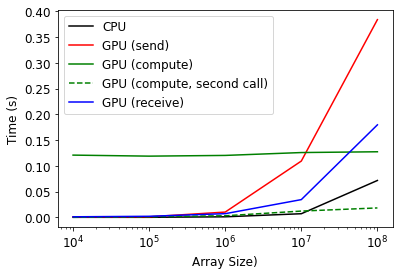

In [178]:
#Timing CPU vs. GPU, function of array size, piecewise benchmarking of GPU code

import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
import time

def cpu_time(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    t0 = time.time()
    a += b
    t1 = time.time()
    return t1-t0

def gpu_time_send(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    
    @cuda.jit
    def addition_kernel(a,b):
        startx = cuda.grid(1)      
        stridex = cuda.gridsize(1) 
        for i in range(startx, a.shape[0], stridex):
            a[i] += b[i]
            
    threads = 64
    blocks = 64
    
    t0 = time.time()
            
    array_a_on_the_gpu = cuda.to_device(a)
    array_b_on_the_gpu = cuda.to_device(b)
    
    t1 = time.time()

    addition_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)

    a = array_a_on_the_gpu.copy_to_host()
    
    return t1-t0

def gpu_time_compute(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    
    @cuda.jit
    def addition_kernel(a,b):
        startx = cuda.grid(1)      
        stridex = cuda.gridsize(1) 
        for i in range(startx, a.shape[0], stridex):
            a[i] += b[i]
            
    threads = 64
    blocks = 64
            
    array_a_on_the_gpu = cuda.to_device(a)
    array_b_on_the_gpu = cuda.to_device(b)
    
    t0 = time.time()

    addition_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)
    cuda.synchronize()
    
    t1 = time.time()

    a = array_a_on_the_gpu.copy_to_host()
    
    return t1-t0

def gpu_time_compute2(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    
    @cuda.jit
    def addition_kernel(a,b):
        startx = cuda.grid(1)      
        stridex = cuda.gridsize(1) 
        for i in range(startx, a.shape[0], stridex):
            a[i] += b[i]
            
    threads = 64
    blocks = 64
            
    array_a_on_the_gpu = cuda.to_device(a)
    array_b_on_the_gpu = cuda.to_device(b)
    
    addition_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)
    
    #only time the second kernel call, as the first time its called requires some initialization
    t0 = time.time()

    addition_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)
    cuda.synchronize()
    
    t1 = time.time()

    a = array_a_on_the_gpu.copy_to_host()
    
    return t1-t0

def gpu_time_receive(arraysize):
    
    a = np.ones([arraysize])
    b = np.ones([arraysize])
    
    @cuda.jit
    def addition_kernel(a,b):
        startx = cuda.grid(1)      
        stridex = cuda.gridsize(1) 
        for i in range(startx, a.shape[0], stridex):
            a[i] += b[i]
            
    threads = 64
    blocks = 64
            
    array_a_on_the_gpu = cuda.to_device(a)
    array_b_on_the_gpu = cuda.to_device(b)
    
    addition_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)
    
    t0 = time.time()

    a = array_a_on_the_gpu.copy_to_host()
    
    t1 = time.time()
    
    return t1-t0
    
array_sizes = [10000, 100000, 1000000, 10000000, 100000000]
cpu_times = []
gpu_times_s = []
gpu_times_c = []
gpu_times_c2 = []
gpu_times_r = []
for i in range(len(array_sizes)):
    cpu_times.append(cpu_time(array_sizes[i]))
    gpu_times_s.append(gpu_time_send(array_sizes[i]))
    gpu_times_c.append(gpu_time_compute(array_sizes[i]))
    gpu_times_c2.append(gpu_time_compute2(array_sizes[i]))
    gpu_times_r.append(gpu_time_receive(array_sizes[i]))

plt.xscale('log')
plt.rcParams.update({'font.size': 12})
plt.plot(array_sizes, cpu_times, "k")
plt.plot(array_sizes, gpu_times_s, "r")
plt.plot(array_sizes, gpu_times_c, "g")
plt.plot(array_sizes, gpu_times_c2, "g--")
plt.plot(array_sizes, gpu_times_r, "b")
plt.legend(["CPU", "GPU (send)", "GPU (compute)", "GPU (compute, second call)", "GPU (receive)"])
plt.xlabel("Array Size)")
plt.ylabel("Time (s)")
plt.show()

### Here the expected result is obtained: for large array sizes, the GPU is indeed faster due to the benefits of parallel computation! How can these results be obtained in general?

Most of the compute time is spent sending/receiving data to/from the GPU. In order to minimize this overhead, ideally data will be sent once to the GPU, and *many*, *more complex* computations are done upon the data, before finally retrieving the result. As there is a (roughly) set amount of overhead, if a calculation takes less than about a second normally, GPU computing likely will not improve its runtime! 

The below code block shows the benchmarking for the more complicated computation from above (the AGM algorithm):

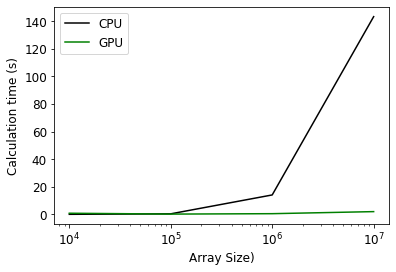

Speed up of final test: 71.79909116021703


In [179]:
#Timing CPU vs. GPU, function of array size, AGM algorithm

import numpy as np
import numba
from numba import cuda
import matplotlib.pyplot as plt
import time

def agm_time(a,b):
    t0 = time.time()
    for step in range(2000):
        c = a
        d = b
        a = 0.5*(c+d)
        b = np.sqrt(c*d)
    t1 = time.time()
    return t1-t0

def agm_time_GPU(a,b):
    t0 = time.time()
    array_a_on_the_gpu = cuda.to_device(a)
    array_b_on_the_gpu = cuda.to_device(b)

    #define our CUDA kernel, matching the computation of interest within the loop (+ addition of indices)
    @cuda.jit
    def agm_kernel(a,b):
        threadID = cuda.grid(1)
        num_threads = cuda.gridsize(1)
        for i in range(threadID, a.shape[0], num_threads): 
            #other than renaming the kernel, this is the only section that changed
            for step in range(2000):
                c = a[i]
                d = b[i]
                a[i] = 0.5*(c+d)
                b[i] = math.sqrt(c*d) #notice use of math function for sqrt

    threads = 64
    blocks = 64

    agm_kernel[threads, blocks](array_a_on_the_gpu,array_b_on_the_gpu)

    a = array_a_on_the_gpu.copy_to_host()
    t1 = time.time()
    return t1-t0
    

array_sizes = [10000, 100000, 1000000, 10000000] #100m would take ~30 minutes on CPU, feel free to test if you want!
cpu_times = []
gpu_times = []
for i in range(len(array_sizes)):
    a = np.ones(array_sizes[i])
    b = np.arange(array_sizes[i]+0.0) #again, convert this to float to avoid integer math unintentionally
    cpu_times.append(agm_time(a,b))
    gpu_times.append(agm_time_GPU(a,b))
    
plt.xscale('log')
plt.rcParams.update({'font.size': 12})
plt.plot(array_sizes, cpu_times, "k")
plt.plot(array_sizes, gpu_times, "g")
plt.legend(["CPU", "GPU"])
plt.xlabel("Array Size)")
plt.ylabel("Calculation time (s)")
plt.show()

print("Speed up of final test: "+str(cpu_times[3]/gpu_times[3]))

# Race Conditions

In parallel code, all threads operate independently, and (this is key!) in no particular order. Therefore, if the order of computations affects the final result, depending on which order the parallel operations happen to operate in, you can get differing results. This is one example of a *race condition*. 

A simple example: consider the array [1, 1]. For both elements, replace it with the sum of both elements.

Intended behavior: Read both values, then replace both array elements with sum of these previously read values. Final result: [2, 2]

Sequential behavior 1: Compute the sum for the left value (intermediate result: [2, 1]), then for the right value (final result: [2, 3]).

Sequential behavior 2: Compute the sum for the right value (intermediate result: [1, 2]), then for the left value (final result: [3, 2]).

The below code illustrates this. Changing the number of threads from 1 to 2 changes the result of the GPU calculation!

In [187]:
def cpu_neighbor_addition():
    a = np.arange(2)+1 #[1 2]
    
    #the numpy.roll function returns the array, with all elements shifted by a 
    #    number of places given by the second parameter, shifted along 
    #    the array axis given by the third parameter
    #Equivalent to adding the value of the "other" position in the array
    a = a+np.roll(a, 1, 0) 
    
    return a

def gpu_neighbor_addition():
    
    
    arraysize = 2
    a = np.arange(arraysize)+1 #[1 2]
    
    @cuda.jit
    def addition_kernel_neighbors(a):
        startx = cuda.grid(1)      
        stridex = cuda.gridsize(1) 
        for i in range(startx, a.shape[0], stridex):
            a[i%arraysize] = a[i%arraysize]+a[(i+1)%arraysize] #modular arithmetic to wrap around the array
            
    threads = 1 #try 1 or 2 here
    blocks = 1
            
    array_a_on_the_gpu = cuda.to_device(a)

    addition_kernel_neighbors[threads, blocks](array_a_on_the_gpu)

    a = array_a_on_the_gpu.copy_to_host()
    return a

print(cpu_neighbor_addition())
print(gpu_neighbor_addition()) #to match expected numpy behavior, should return [3 3]

[3 3]
[3 5]


# First Example Material System: Diffusion

Diffusion, in an ideal system, is governed by Fick's laws, which simplify to the following partial differential equation:

$$ \frac{dC}{dt} = D\nabla^2 C $$ 
$$\textit{or}$$
$$ \frac{dC}{dt} = D(\frac{d^2C}{dx^2} + \frac{d^2C}{dy^2}) \text{,   (in 2D)}$$

Using finite difference approximations, with time step $\Delta$t and distance between values $\Delta$x, this second equation may be written as

$$ C^{t+1}_{x,y} = C^{t}_{x,y} + \frac{D\Delta t}{\Delta x^2} (C^{t}_{x-1,y}+C^{t}_{x+1,y}+C^{t}_{x,y-1}+C^{t}_{x,y+1}-4C^{t}_{x,y}) $$

This equation is applied everywhere in the center of the domain, with differing rules applied at the edges defining the boundary conditions of the simulation. Two main coding strategies in numpy to acquire the values of neighboring cells (array rolling and slicing) naturally produce two different types of boundary conditions, periodic and dirichlet (fixed value) respectively. These two boundary conditions are shown below. 

Further comparisons between CPU and GPU code will exclusively use dirichlet (fixed value) boundary conditions due to its simplicity (don't simulate the edges of the domain).

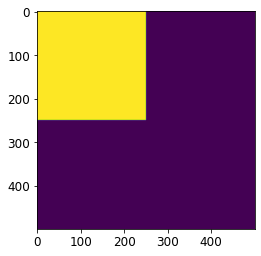

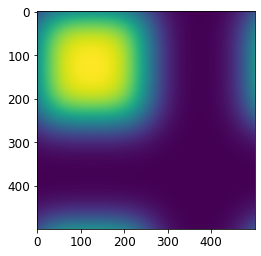

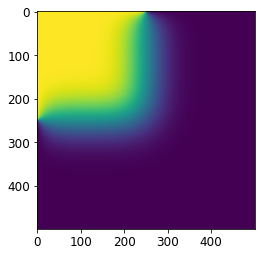

In [188]:
import numpy as np
import matplotlib.pyplot as plt

def diffusion_CPU_periodic(array):
    c = array.copy() #don't propagate results to original array, in order to reuse original
    D = 0.2
    dt = 1.
    dx = 1.
    idx2 = 1./(dx*dx)
    for step in range(5000):
        c += D*dt*idx2*(np.roll(c, 1, 0)+np.roll(c, -1, 0)+np.roll(c, 1, 1)+np.roll(c, -1, 1)-4*c)
    return c

def diffusion_CPU_dirichlet(array):
    c = array.copy() #don't propagate results to original array, in order to reuse original
    D = 0.2
    dt = 1.
    dx = 1.
    idx2 = 1./(dx*dx)
    for step in range(5000):
        c_xm = c[0:-2,1:-1]
        c_xp = c[2:,1:-1]
        c_ym = c[1:-1,0:-2]
        c_yp = c[1:-1,2:]
        c_center = c[1:-1,1:-1]
        c_center += D*dt*idx2*(c_xm+c_xp+c_ym+c_yp-4*c_center)
    return c

c = np.zeros([500,500])
c[0:250,0:250] = 1

plt.imshow(c) #original state
plt.show()
plt.imshow(diffusion_CPU_periodic(c))
plt.show()
plt.imshow(diffusion_CPU_dirichlet(c))
plt.show()

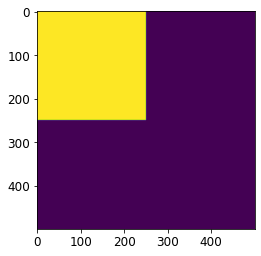

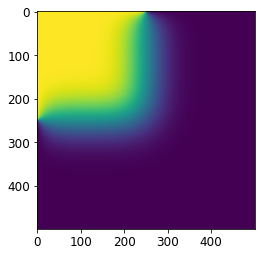

CPU: 13.739572525024414 seconds


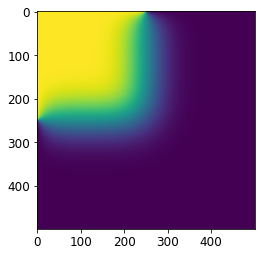

GPU: 1.0361242294311523 seconds


In [193]:
import time

def diffusion_GPU_dirichlet(array):
    
    array_out = array.copy()
    
    array_gpu = cuda.to_device(array)
    array_out_gpu = cuda.to_device(array_out)
    
    @cuda.jit
    def diffusion_kernel(c, c_out):
        startx, starty = cuda.grid(2)      
        stridex, stridey = cuda.gridsize(2) 
        D = 0.2
        dt = 1.
        dx = 1.
        idx2 = 1./(dx*dx)
        for i in range(starty+1, c.shape[0]-1, stridey):
            for j in range(startx+1, c.shape[1]-1, stridex):
                c_xm = c[i-1][j]
                c_xp = c[i+1][j]
                c_ym = c[i][j-1]
                c_yp = c[i][j+1]
                c_center = c[i][j]
                c_out[i][j] = c_center + D*dt*idx2*(c_xm+c_xp+c_ym+c_yp-4*c_center)
            
    threads = (8,8)
    blocks = (8,8)
    
    for i in range(5000):
        diffusion_kernel[threads, blocks](c_gpu, c_out_gpu)
        cuda.synchronize()
        c_gpu, c_out_gpu = c_out_gpu, c_gpu

    c = array_gpu.copy_to_host()
    return c

c = np.zeros([500,500])
c[0:250,0:250] = 1

plt.imshow(c) #original state
plt.show()
t0 = time.time()
cpu_result = diffusion_CPU_dirichlet(c)
t1 = time.time()
plt.imshow(cpu_result)
plt.show()
print("CPU: "+str(t1-t0)+" seconds")
t0 = time.time()
gpu_result = diffusion_GPU_dirichlet(c)
t1 = time.time()
plt.imshow(gpu_result)
plt.show()
print("GPU: "+str(t1-t0)+" seconds")

# Cahn-Allen Model

Very similar to the Diffusion model, but instead begins with the Functional expression for energy:

$$ F = \int_V I dV = \int_V (\frac{\epsilon^2}{2}|\nabla \phi|^2 + W\phi^2(1-\phi)^2) dV $$

Then use variational calculus to derive a rate equation (equivalent to the Diffusion equation):

$$ \frac{d\phi}{dt} = -M(\frac{\delta F}{\delta \phi}) = -M(\frac{\partial I}{\partial \phi} - \nabla \cdot \frac{\partial I}{\partial \nabla \phi}) $$

$$ \frac{d\phi}{dt} = M(\epsilon^2\nabla^2\phi - W(4\phi^3 - 6\phi^2 + 2\phi)) $$

Slight differences will be visible between CPU and GPU code, as GPU natively uses 32 bit floats


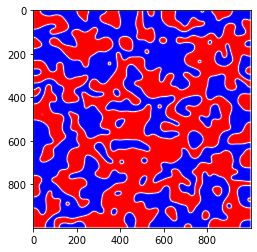

CPU Time: 55.50967788696289


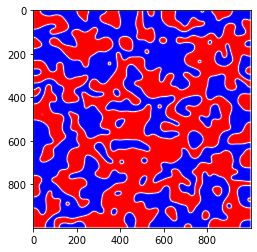

GPU Time: 0.7506442070007324


In [44]:
def cahnallen_CPU_dirichlet(array, steps):
    phi = array.copy()
    M = 0.2
    dt = 1.
    dx = 1.
    idx2 = 1./(dx*dx)
    e = 1.
    e2 = e*e
    W = 0.2
    for i in range(steps):
        phi_xm = phi[0:-2,1:-1]
        phi_xp = phi[2:,1:-1]
        phi_ym = phi[1:-1,0:-2]
        phi_yp = phi[1:-1,2:]
        phi_center = phi[1:-1,1:-1]
        phi_center += M*dt*(e2*(phi_xm+phi_xp+phi_ym+phi_yp-4*phi_center)*idx2 - W*(4*phi_center**3 - 6*phi_center**2 + 2*phi_center))
    return phi
        
def cahnallen_GPU_dirichlet(array, steps):
    
    array_out = array.copy()
    
    array_gpu = cuda.to_device(array)
    array_out_gpu = cuda.to_device(array_out)
    
    @cuda.jit
    def cahnallen_kernel(c, c_out):
        startx, starty = cuda.grid(2)      
        stridex, stridey = cuda.gridsize(2) 
        M = 0.2
        dt = 1.
        dx = 1.
        idx2 = 1./(dx*dx)
        e = 1.
        e2 = e*e
        W = 0.2
        for i in range(starty+1, c.shape[0]-1, stridey):
            for j in range(startx+1, c.shape[1]-1, stridex):
                c_out[i][j] = c[i][j] + M*dt*((e2*(c[i+1][j]+c[i-1][j]+c[i][j+1]+c[i][j-1]-4*c[i][j]))*idx2 - W*(4*c[i][j]**3 - 6*c[i][j]**2 + 2*c[i][j])) 
            
    threads = (8,8)
    blocks = (8,8)
    
    for i in range(steps):
        cahnallen_kernel[threads, blocks](array_gpu, array_out_gpu)
        cuda.synchronize()
        array_gpu, array_out_gpu = array_out_gpu, array_gpu

    c = array_gpu.copy_to_host()
    return c

phi = 0.01*np.random.random([1000,1000])+0.495

t0 = time.time()
cpu_result = cahnallen_CPU_dirichlet(phi, 1000)   
t1 = time.time()
plt.imshow(cpu_result, cmap = "bwr")
plt.show()
print("CPU Time: "+str(t1-t0))

t0 = time.time()
gpu_result = cahnallen_GPU_dirichlet(phi, 1000)
t1 = time.time()
plt.imshow(gpu_result, cmap = "bwr")
plt.show()
print("GPU Time: "+str(t1-t0))

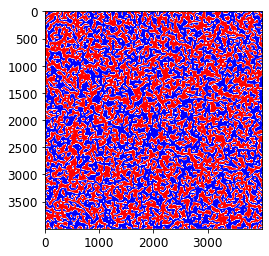

GPU Time: 3.1221916675567627


In [209]:
phi = 0.01*np.random.random([4000,4000])+0.495

#expected CPU time: 16x longer than above
t0 = time.time()
gpu_result = cahnallen_GPU_dirichlet(phi, 1000)
t1 = time.time()
plt.imshow(gpu_result, cmap = "bwr")
plt.show()
print("GPU Time: "+str(t1-t0))
#speedup on my machine: 284.5x

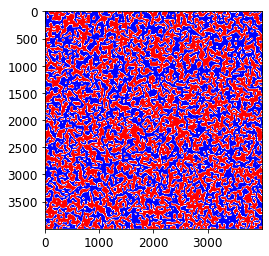

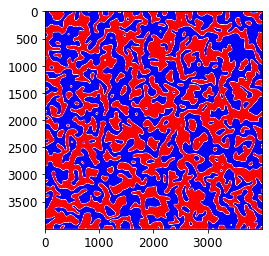

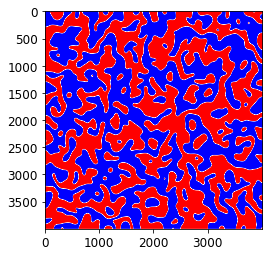

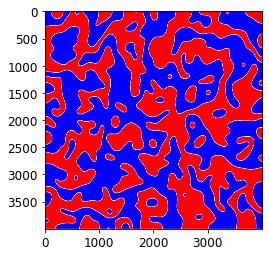

In [217]:
#show evolution over time

phi = 0.01*np.random.random([4000,4000])+0.495

gpu_result1 = cahnallen_GPU_dirichlet(phi, 1000)
plt.imshow(gpu_result1, cmap = "bwr")
plt.show()

gpu_result2 = cahnallen_GPU_dirichlet(gpu_result1, 4000)
plt.imshow(gpu_result2, cmap = "bwr")
plt.show()

gpu_result3 = cahnallen_GPU_dirichlet(gpu_result2, 5000)
plt.imshow(gpu_result3, cmap = "bwr")
plt.show()

gpu_result4 = cahnallen_GPU_dirichlet(gpu_result3, 10000)
plt.imshow(gpu_result4, cmap = "bwr")
plt.show()

# Warren1995 Model

From Warren, J. A., and W. J. Boettinger. “Prediction of Dendritic Growth and Microsegregation Patterns in a Binary Alloy Using the Phase-Field Method.” Acta Metallurgica et Materialia, vol. 43, no. 2, Feb. 1995, pp. 689–703. DOI.org (Crossref), https://doi.org/10.1016/0956-7151(94)00285-P.

Reproduces (approximately) figure 1 from the paper. Takes about 30 seconds to run on my machine!

This is the first simulation which requires pyphasefield to run.

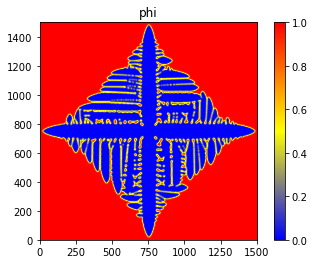

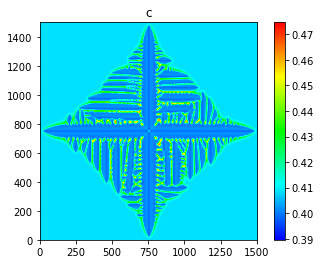

Simulation time: 31.342675924301147 seconds


In [18]:
import pyphasefield.Engines as engines
import time

sim = engines.Warren1995(dimensions=[1500, 1500])
sim.set_framework("GPU_SERIAL")
sim.set_dx(0.000000046)
sim.set_temperature_type("ISOTHERMAL") 
sim.set_temperature_initial_T(1574.)
sim.set_save_path("data/Warren1995")
sim.set_boundary_conditions(["NEUMANN", "NEUMANN"])
user_data = {
    "initial_concentration_array":[0.40831] #
    
}
sim.set_user_data(user_data)

sim.initialize_fields_and_imported_data()

t0 = time.time()
sim.simulate(6000)
t1 = time.time()

#uncomment the below line to save a file checkpoint for the simulation
#sim.save_simulation()

#Show images. Change first boolean to True to save images as files
sim.plot_simulation(save_images=False, show_images=True)
print("Simulation time: "+str(t1-t0)+" seconds")

# NCGPU Model - Columnar Dendritic Growth in SLM

The NCGPU (N-Component, GPU) model is defined by the following Functional Expression:

$$ F = \int_\Omega (f_{int} + f_{bulk} + f_{well} + f_{ori} + f_{q2} + \lambda(1-\sqrt{\sum q_i^2}) $$
$$ f_{int} = \frac{\epsilon_\phi^2\eta T}{2}|\nabla \phi|^2 $$
$$ f_{bulk} = G_L(\textbf{c}, T) + h(\phi)(G_S(\textbf{c}, T) - G_L(\textbf{c}, T)) $$
$$ f_{well} = \sum_i c_iW_ig(\phi) $$
$$ f_{ori} = 2HTp(\phi)|\nabla \textbf{q}| $$
$$ f_{q2} = \frac{\epsilon_q^2}{2}|\nabla \textbf{q}|^2 $$
$$ h(\phi) = \phi^3(6\phi^2 - 15\phi + 10) $$
$$ g(\phi) = \phi^2(1-\phi)^2 $$
$$ p(\phi) = \phi^2 $$
$$ \eta = 1 - 3\gamma_\epsilon + 4\gamma_\epsilon\frac{\psi_x^4 + \psi_y^4 + \psi_z^4}{|\nabla \phi|^4} $$

Here, $\phi$, $\textbf{c}$, $q_i$, and T are field variables (but T is not simulated - independent parameter). $G_L$ and $G_S$ are thermodynamic functions obtained from pycalphad, and $\psi$ terms are the gradients of $\phi$, rotated by the quaternion q. Other variables are material parameters of the model.

Below is a sample simulation of columnar growth emerging from a random assortment of nuclei. Uses a simplified version of the MatCalc Nickel database. Approximates Inconel 718 as:

1.1 at% Aluminum

21.2 at% Chromium

19.2 at% Iron

1.8 at% Molybdenum

3.1 at% Niobium

52.4 at% Nickel

Remainder (1.2 at%) Titanium



Runs in a thermal gradient of 1.3e7 K/m, with a cooling rate of -1.83e6 K/s. Dendrites grow from left to right

Requires pycalphad! (Version 0.8.4 for now, working to update pyphasefield to use latest version...)

MatCalc: https://www.matcalc.at/index.php/databases/open-databases

Beware: takes about 40 minutes to run on my machine!

In [23]:
import pyphasefield as ppf
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt
import numpy as np
import time

#this is in a separate block, as loading the TDB takes a long time! Once loaded it can be reused easily
tdbc = ppf.TDBContainer("mc_simplified.tdb", ["FCC_A1", "LIQUID"], ["AL", "CR", "FE", "MO", "NB", "NI", "TI"])

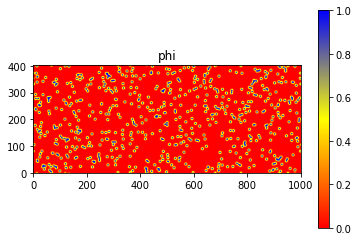

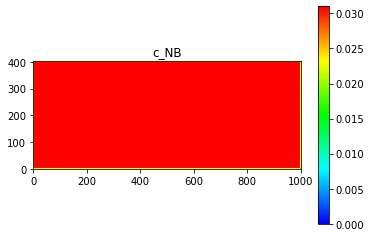

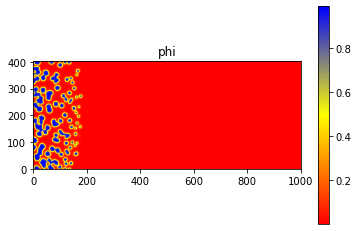

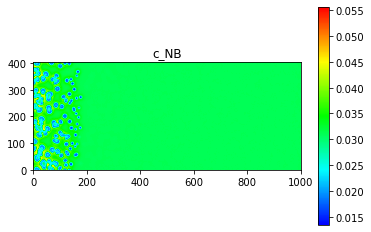

Approximate completion time: 2306.6501557826996 seconds


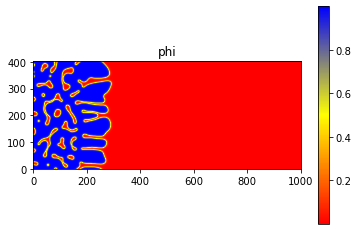

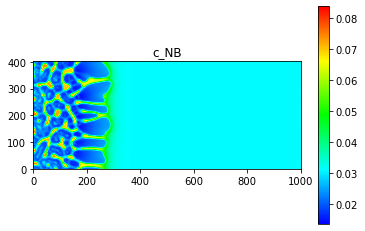

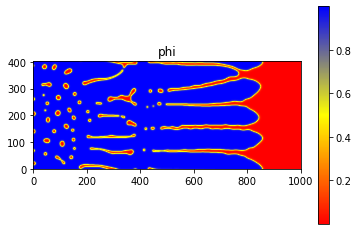

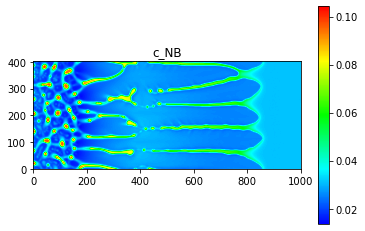

In [40]:
def run_dendrite_simulation(G, K):
    
    #G: Thermal gradient (K/cm)
    #K: Thermal cooling rate (K/s)
    
    size_x = 1000
    size_y = 400

    sim = engines.NCGPU(dimensions=[size_y, size_x])

    #initialize non-array parameters
    sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
    sim.set_dx(0.0000008)
    sim.set_time_step_counter(0)
    sim.set_temperature_type("LINEAR_GRADIENT") 
    sim.set_temperature_initial_T(1584.)
    sim.set_temperature_dTdx(G)
    sim.set_temperature_dTdy(0.)
    sim.set_temperature_dTdz(0.)
    sim.set_temperature_dTdt(K)
    sim.set_temperature_units("K")
    sim.set_tdb_container(tdbc)
    sim.set_save_path("data/dendritic_growth_"+str(G)+"_"+str(K))
    sim.set_autosave_flag(True)
    sim.set_autosave_save_images_flag(True)
    sim.set_autosave_rate(15000)
    sim.set_boundary_conditions(["NEUMANN", "PERIODIC"])

    numseeds = int(64*size_x*size_y/(200**2)) #approximately 200nm spaced nuclei for initial conditions
    
    data = {
        "d_ratio":2.5,
        "noise_c":1.,
        "melt_angle":0.,
        "sim_type":"seeds",
        "number_of_seeds":numseeds, #0 here for no randomly oriented seeds
        "initial_concentration_array":[0.011, 0.212, 0.192, 0.018, 0.031, 0.524]
    }
    sim.set_user_data(data)

    #initialize simulation arrays, all parameter changes should be BEFORE this point!
    sim.initialize_fields_and_imported_data()
    sim.user_data["H"] = 0.00000000001
    sim.user_data["M_qmax"] = 12000000000.

    #change array data here, for custom simulations
    #num_seeds = int(sim.dimensions[0]*(sim.dx*10000000)/250)
    #d_size = 250/(sim.dx*10000000)
    #for i in range(num_seeds):
        #sim.fields[0].data, sim.fields[1].data, sim.fields[2].data = ppf.make_seed(sim.fields[0].data, sim.fields[1].data, sim.fields[2].data, int(0.5*d_size), int((i+0.5)*d_size), 0., int(0.25*d_size))

    sim.dt = 0.000000001
    plt.imshow(sim.fields[0].data)
    time_steps_required = 60000
    sim.set_autosave_rate(time_steps_required//2)
    sim.plot_simulation(fields=[0,7])
    t0 = time.time()
    sim.simulate(1000)
    sim.plot_simulation(fields=[0,7])
    t1 = time.time()
    print("Approximate completion time: "+str((t1-t0)*59)+" seconds")
    sim.simulate(29000)
    sim.plot_simulation(fields=[0,7])
    sim.simulate(30000)
    sim.plot_simulation(fields=[0,7])

run_dendrite_simulation(130000., -1830000.)